In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import sys
import numpy as np
sys.path.append("/global/cscratch1/sd/zuntz/TXPipe")
import txpipe

# Examining TXPipe + RAIL outputs

In [2]:
data_dir = "/global/cscratch1/sd/zuntz/TXPipe/data/cosmodc2-nz/outputs"

In [3]:
!ls -lh $data_dir

total 477G
-rw-r--r-- 1 zuntz zuntz  31M Oct  5 05:00 ideal_specz_catalog.pq
-rw-r--r-- 1 zuntz zuntz 1.2M Oct  5 05:02 lens_direct_calibration_model.pkl
-rw-r--r-- 1 zuntz zuntz  349 Oct  5 05:02 lens_photoz_model.pkl
-rw-r--r-- 1 zuntz zuntz 474G Oct  6 05:05 lens_photoz_pdfs.hdf5
-rw-r--r-- 1 zuntz zuntz 308K Oct  7 05:58 lens_photoz_realizations.hdf5
-rw-r--r-- 1 zuntz zuntz  45K Oct  7 05:58 lens_photoz_stack.hdf5
-rw-r--r-- 1 zuntz zuntz 1.6G Oct  7 05:55 lens_tomography_catalog.hdf5
drwxrwx--- 2 zuntz zuntz 4.0K Oct  7 05:53 old
-rw-r--r-- 1 zuntz zuntz  29K Oct  5 05:48 shear_photoz_stack.hdf5
-rw-r--r-- 1 zuntz zuntz 801M Oct  5 04:57 shear_tomography_catalog.hdf5
-rw-r--r-- 1 zuntz zuntz 857K Oct  5 05:02 source_direct_calibration_model.pkl
-rw-r--r-- 1 zuntz zuntz  63K Oct  5 05:48 source_photoz_realizations.hdf5
-rw-r--r-- 1 zuntz zuntz 1.2M Oct  5 05:02 spectroscopic_catalog.hdf5
-rw-r--r-- 1 zuntz zuntz 1.3M Oct  5 05:01 specz_catalog_pq.pq
-rw-r--r-- 1 zuntz zuntz  41K O

# Loading and normalizing results

In [4]:
def normalize(z, nz):
    r = z @ nz
    return nz / r

# Load the truth data
nz_true = []
with txpipe.data_types.NOfZFile(f"{data_dir}/true_lens_photoz_stack.hdf5", "r") as f:
    nbin = f.get_nbin('lens')
    for i in range(nbin):
        z_true, n_z_i = f.get_n_of_z('lens', i)
        n_z_i = normalize(z_true, n_z_i)
        nz_true.append(n_z_i)

# Load the fiducial estimates from NZ-DIR
nz_fid = []
with txpipe.data_types.NOfZFile(f"{data_dir}/lens_photoz_stack.hdf5", "r") as f:
    for i in range(nbin):
        z_fid, n_z_i = f.get_n_of_z('lens', i)
        n_z_i = normalize(z_fid, n_z_i)
        nz_fid.append(n_z_i)

# Load the bootstrap realizations from NZ-DIR
with h5py.File(f"{data_dir}/lens_photoz_realizations.hdf5") as f:
    z_real = f['realizations/z'][:]
    nz_real = f['realizations/pdfs'][:]

nreal = len(nz_real[0])
nz_real = np.swapaxes(nz_real, 0, 1)
for i in range(nbin):
    for j in range(nreal):
        nz_real[i][j] = normalize(z_real, nz_real[i][j])

In [5]:
nz_real.shape

(5, 20, 301)

# Comparison of NZ-DIR fiducial estimate to truth

Text(0, 0.5, 'n(z)')

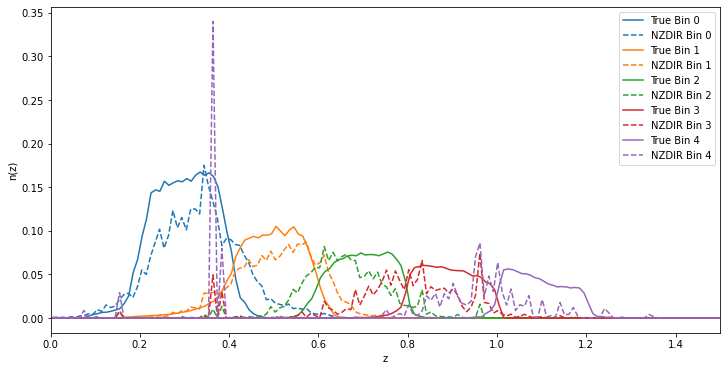

In [6]:
plt.figure(figsize=(12,6))
for i in range(5):
    line, = plt.plot(z_true, nz_true[i],'-', label=f'True Bin {i}')
    plt.plot(z_fid, nz_fid[i],'--', label=f'NZDIR Bin {i}', color=line.get_color())
plt.xlim(0, 1.5)
plt.legend()
plt.xlabel('z')
plt.ylabel(f'n(z)')

# Comparison of realizations generated by NZ-DIR to truth

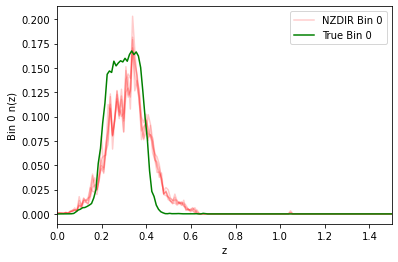

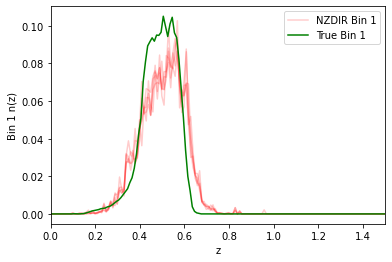

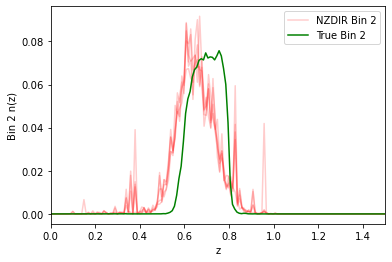

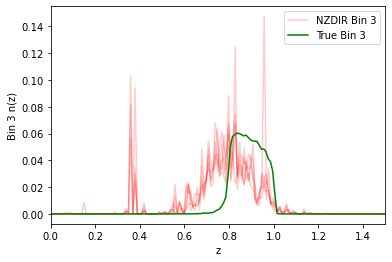

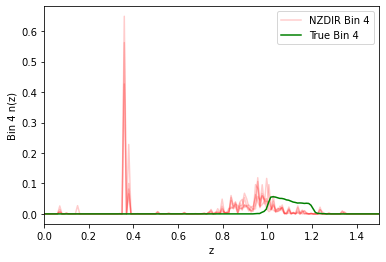

In [7]:
for j in range(nbin):
    plt.figure()
    for i in range(nreal):
        label = f"NZDIR Bin {j}" if i == 0 else None
        plt.plot(z_real, nz_real[j][i], 'r-', alpha=0.2, label=label)

    plt.plot(z_true, nz_true[j], 'g-', label=f'True Bin {j}')
    plt.xlim(0, 1.5)
    plt.legend()
    plt.xlabel('z')
    plt.ylabel(f'Bin {j} n(z)')

# Estimation of the mean shift between truth and NZ-DIR

In [8]:
def get_mean(z, nz):
    return (z * nz).sum() / nz.sum()

for i in range(nbin):
    true_mean = get_mean(z_true, nz_true[i])
    fid_mean = get_mean(z_fid, nz_fid[i])
    real_means = np.array([get_mean(z_real, nz_real[i][j]) for j in range(nreal)])
    delta_z = fid_mean - true_mean
    delta_z_err = (real_means - true_mean).std()
    print(f"Bin {i} delta z = {delta_z:.4f} ± {delta_z_err:.4f}")

Bin 0 delta z = 0.0324 ± 0.0017
Bin 1 delta z = 0.0208 ± 0.0020
Bin 2 delta z = -0.0423 ± 0.0056
Bin 3 delta z = -0.1068 ± 0.0212
Bin 4 delta z = -0.3382 ± 0.1233


In [9]:
with txpipe.data_types.NOfZFile(f"{data_dir}/lens_photoz_stack.hdf5", "r") as f:
    prov = dict(f.file['provenance'].attrs)


# Show configuration used

In [10]:
for key, val in prov.items():
    if key.startswith('config'):
        print(key[7:], '=', val)

aliases = {'tomography_catalog': 'lens_tomography_catalog', 'photometry_catalog': 'photometry_catalog', 'model': 'lens_direct_calibration_model', 'photoz_stack': 'lens_photoz_stack', 'photoz_realizations': 'lens_photoz_realizations'}
catalog_group = photometry
chunk_rows = 1000000
config = examples/cosmodc2/config-nz.yml
cprofile = 
leafsize = 20
mag_prefix = photometry/mag_
memmon = 0
model = None
mpi = True
name = PZRailSummarizeLens
nzbins = 301
pdb = False
photometry_catalog = /global/cfs/cdirs/lsst/groups/WL/users/zuntz/data/cosmoDC2-1.1.4_oneyear/photometry_catalog.hdf5
photoz_realizations = data/cosmodc2-nz/outputs/lens_photoz_realizations.hdf5
photoz_stack = data/cosmodc2-nz/outputs/lens_photoz_stack.hdf5
stage_name = PZRailSummarize
tomography_catalog = data/cosmodc2-nz/outputs/lens_tomography_catalog.hdf5
tomography_name = lens
zmax = 3.0
zmin = 0.0


# Show git version used

In [11]:
git_commit = prov['githead'].strip()
url = f"https://github.com/LSSTDESC/TXPipe/blob/{git_commit}/txpipe/rail/summarize.py"
print(url)


https://github.com/LSSTDESC/TXPipe/blob/11fe45367f1fd92dc589c9e2724759795d53fc36/txpipe/rail/summarize.py


# Show git diffs from that version 
## (Just for amusement - in this case there are no important code diffs)

In [12]:
print(prov['gitdiff'][:1000] + '\n...')

diff --git a/examples/cosmodc2/config-nz.yml b/examples/cosmodc2/config-nz.yml
index 069f1be..aaddc24 100644
--- a/examples/cosmodc2/config-nz.yml
+++ b/examples/cosmodc2/config-nz.yml
@@ -86,16 +86,9 @@ PZEstimatorLens:
     data_path: data/example/rail-bpz-inputs
     chunk_size: 1000000
 
-TXMeanLensSelector:
-    # Mag cuts
-    lens_zbin_edges: [0.0,0.2,0.4]
-    cperp_cut: 0.2
-    r_cpar_cut: 13.5
-    r_lo_cut: 16.0
-    r_hi_cut: 21.6
-    i_lo_cut: 17.5
-    i_hi_cut: 21.9
-    r_i_cut: 2.0
+TXRandomForestLensSelector:
+    lens_zbin_edges: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
+    mag_i_limit: 24.1
 
 
 Inform_NZDirLens:
diff --git a/examples/cosmodc2/pipeline-nz.yml b/examples/cosmodc2/pipeline-nz.yml
index 4e017a0..7bf5ab8 100644
--- a/examples/cosmodc2/pipeline-nz.yml
+++ b/examples/cosmodc2/pipeline-nz.yml
@@ -23,7 +23,7 @@ stages:
       nprocess: 128
       threads_per_process: 1
       nodes: 4
-    - name: TXMeanLensSelector     # select objects for lens bins from the PDFs